# EDA and Preprocessing of combined Data

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import pickle
import seaborn as sns
from sklearn.preprocessing import minmax_scale,MinMaxScaler

In [2]:
# reading stored data file obtained from "Combining_all_data_files.ipynb"

data = pd.read_csv("final_data.csv")
data.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,close_value,volume,open_value,high_value,low_value,close_value_change,change_label,class_sign
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,110.38,41304780,112.82,113.13,110.21,0.0,0.0,1
1,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,110.38,41304780,112.82,113.13,110.21,0.0,0.0,1
2,550803225113157632,AAPL,MacHashNews,2015-01-01,Rumor Roundup: What to expect when you're expe...,0,0,0,110.38,41304780,112.82,113.13,110.21,0.0,0.0,1
3,550802957370159104,AAPL,WaltLightShed,2015-01-01,"An $AAPL store line in Sapporo Japan for the ""...",2,4,4,110.38,41304780,112.82,113.13,110.21,0.0,0.0,1
4,550802855129382912,AAPL,2waystrading,2015-01-01,$AAPL - Will $AAPL Give Second entry opportuni...,0,0,0,110.38,41304780,112.82,113.13,110.21,0.0,0.0,1


#### Before processing, let us determine which all columns can be useful features so that we can focus on processing only those columns

In [3]:
print("Columns available in the data are :\n",data.columns)

Columns available in the data are :
 Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num', 'retweet_num', 'like_num', 'close_value', 'volume',
       'open_value', 'high_value', 'low_value', 'close_value_change',
       'change_label', 'class_sign'],
      dtype='object')


<li><b> tweet_id: </b> This will not be an useful feature since it identifies each tweet uniquely in tweets table but does not convey any info related to stock price changes. </li>
<li><b> ticker_symbol: </b> While this was given in order to link each tweet with a company but the task that we have is to predict stock price changes for a company. This price changes can be different for each company hence model can be given this as a feature to identify the price change uniquely for each company. </li>
<li><b> writer:  </b> 'writer' column can be considered as feature but embedding writer vector with available data is not efficient since if we encode writers with onehotencoding then that will be a large dimensional vector. </li>
<li><b> post_date: </b> This won't be an useful feature but dates can be used to combine tweets and vectors as discussed in abstract </li>
<li><b> body: </b> This is the actual tweet text and the most informative feature that can be used. </li>
<li><b> retweet_num: </b> Number of retweets indicate the reach of a tweet and this can be useful feature to predict the change in stock price. </li>
<li><b> comment_num: </b> Similar comment as that of 'retweet_num' can be made related to comment number. </li>
<li><b> like_num: </b> Similar comment as that of 'retweet_num' can be made related to like number. </li>
<li><b> close_value: </b> This is used for class label generation and also the prediction has to be made related to this entity hence this can not be used as a feature. </li>
<li><b> volume: </b> Traded volume can also be used as a class label but this is a part of experimentation. We can predict volume traded based on the tweets for that day. </li>
<li><b> open_value: </b> Similar to closing value, open value can also be used for class label generation. </li>
<li><b> high_value: </b> Not so useful when it comes to prediction of relative change in price and also while using the model in real world, this data may not be available hence this should not be used as a feature. </li>
<li><b> low_value: </b> Not so useful when it comes to prediction of relative change in price and also while using the model in real world, this data may not be available hence this should not be used as a feature.</li>
<li><b> change_label, class_sign : </b> These are the class labels that we need to predict </li>

In [4]:
print("Number of different distinct writers in available data: ",len(data['writer'].unique()))

Number of different distinct writers in available data:  140132


Here we can see that number of distinct writers are 38084 which is not suitable for vectorization

### Now let us see if tweets are actually correlated with % price change or not

<li> The data contains tweets for dates and respective price changes from 2015 to 2019. The penetration of social media incresed with time. Hence the impact of social media increased with time in all aspects. </li>
<li> Since it will not be possible to visualise correlation for all days, below cell plots number of tweets on a day and respective price change for each company for last 100 days in the dataset. </li>

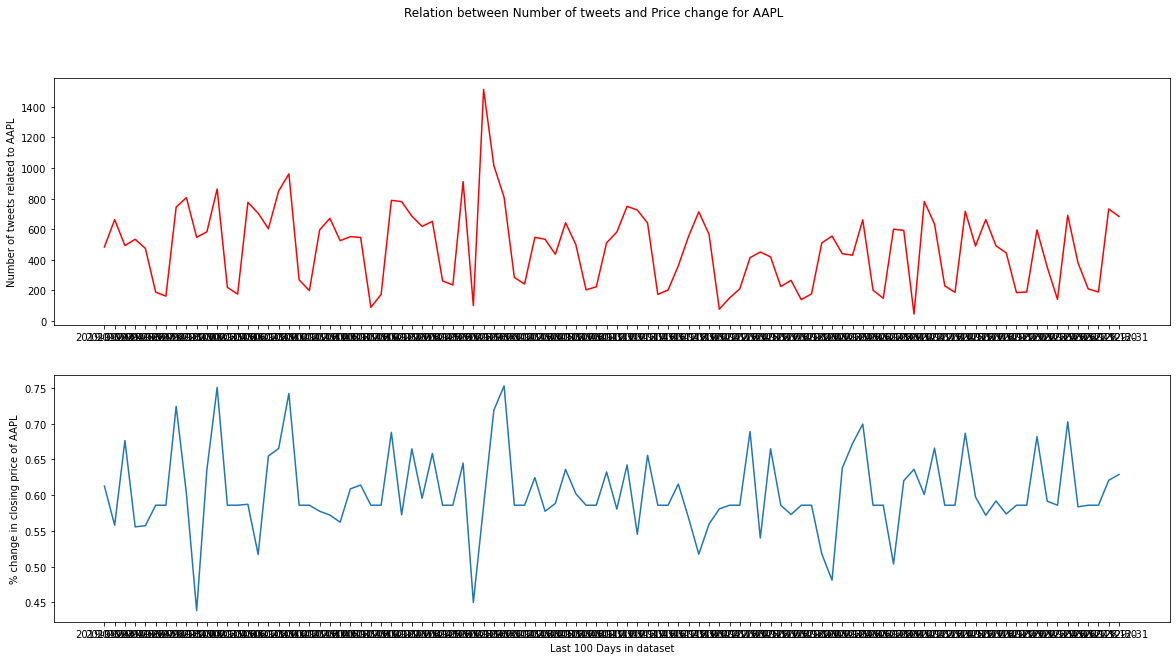

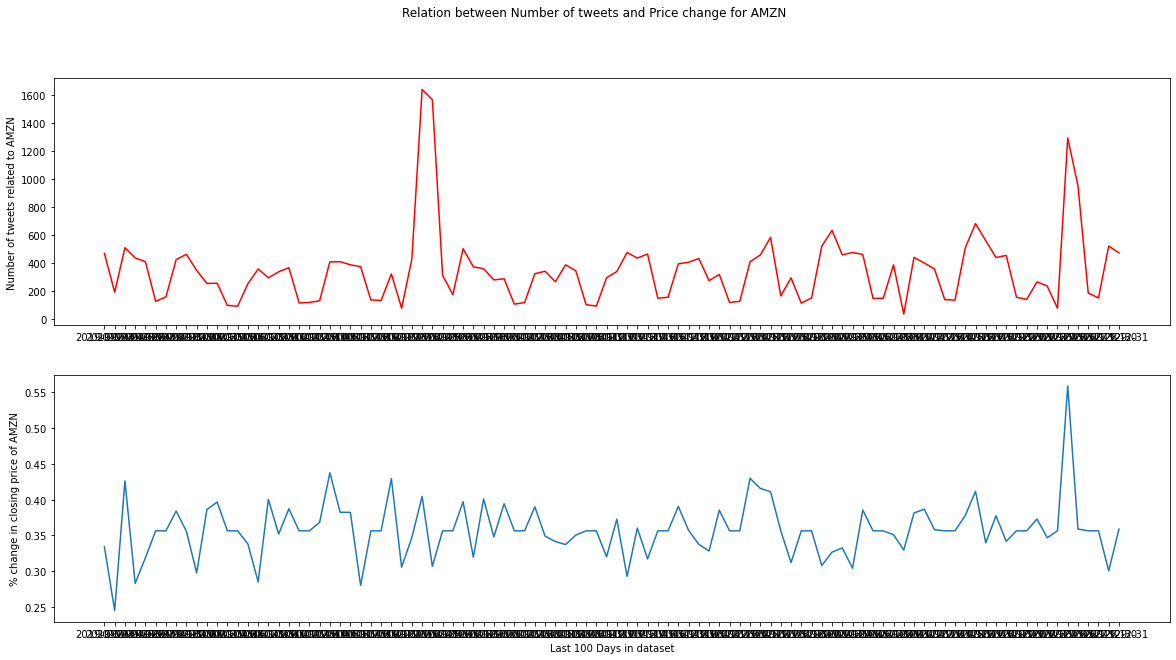

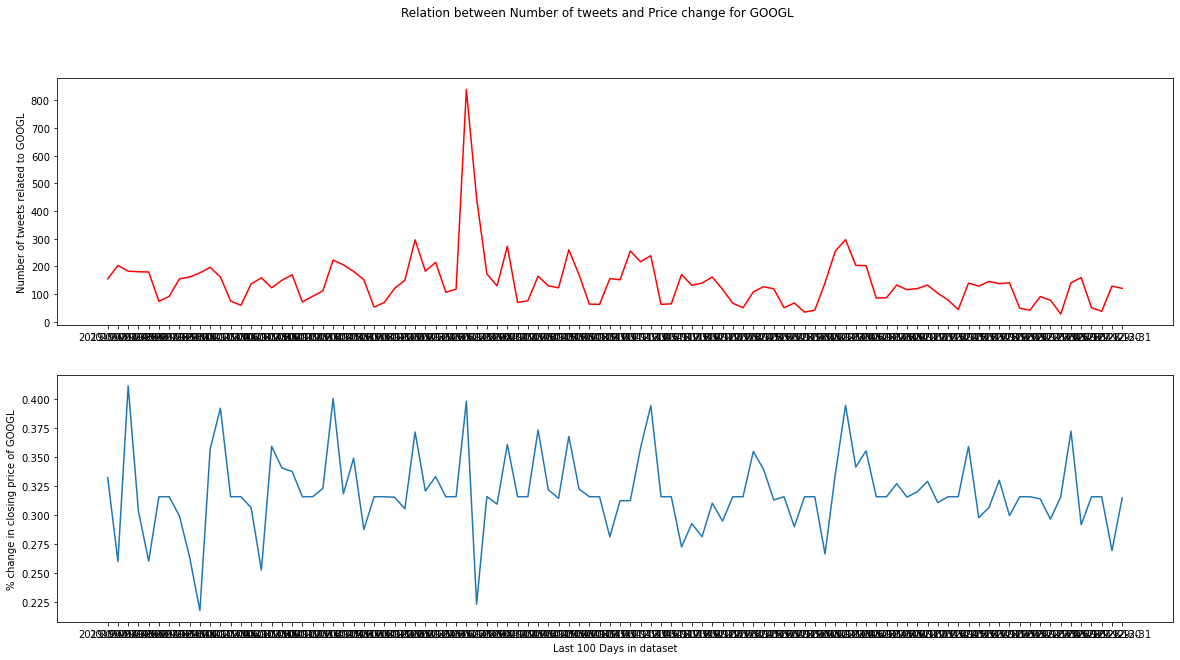

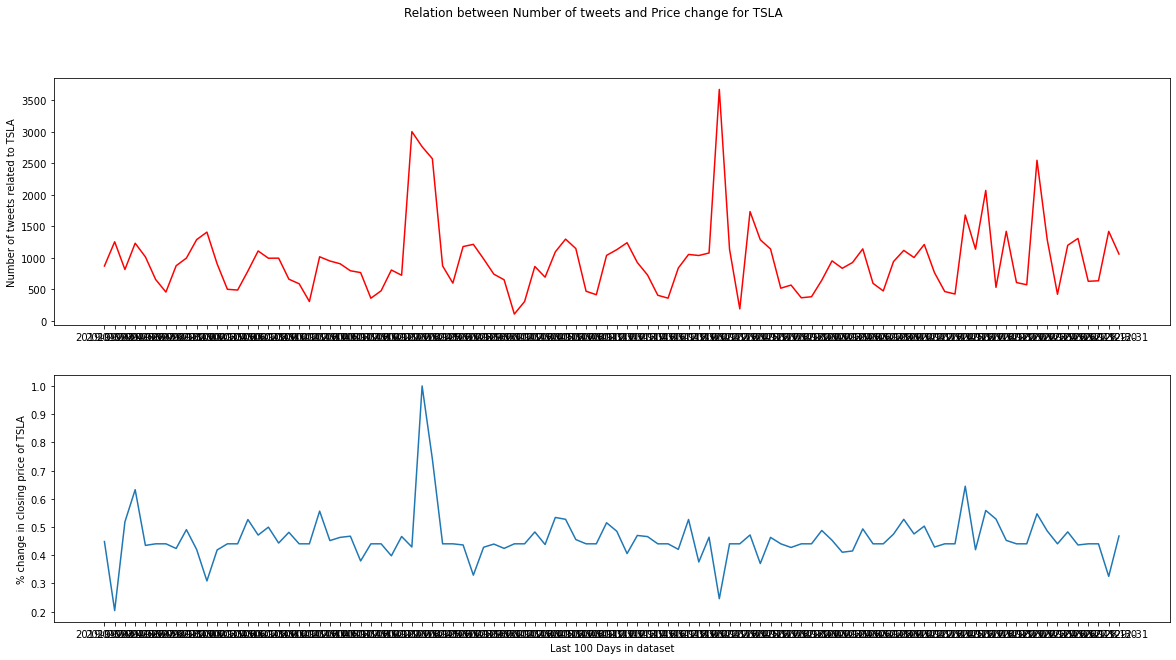

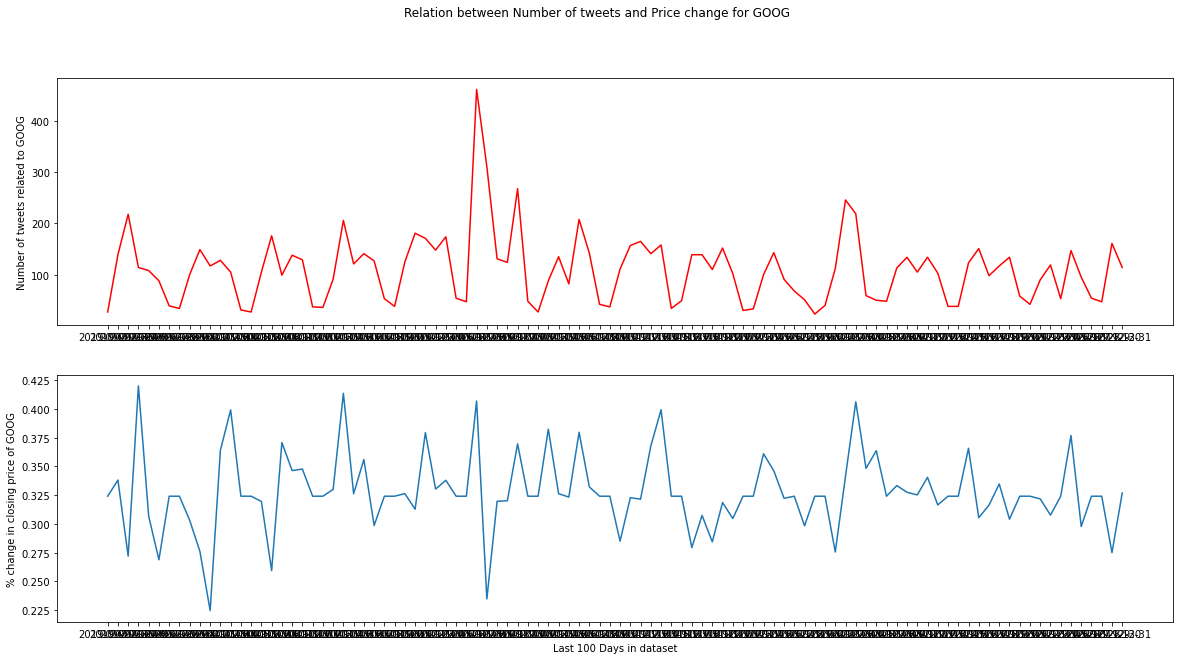

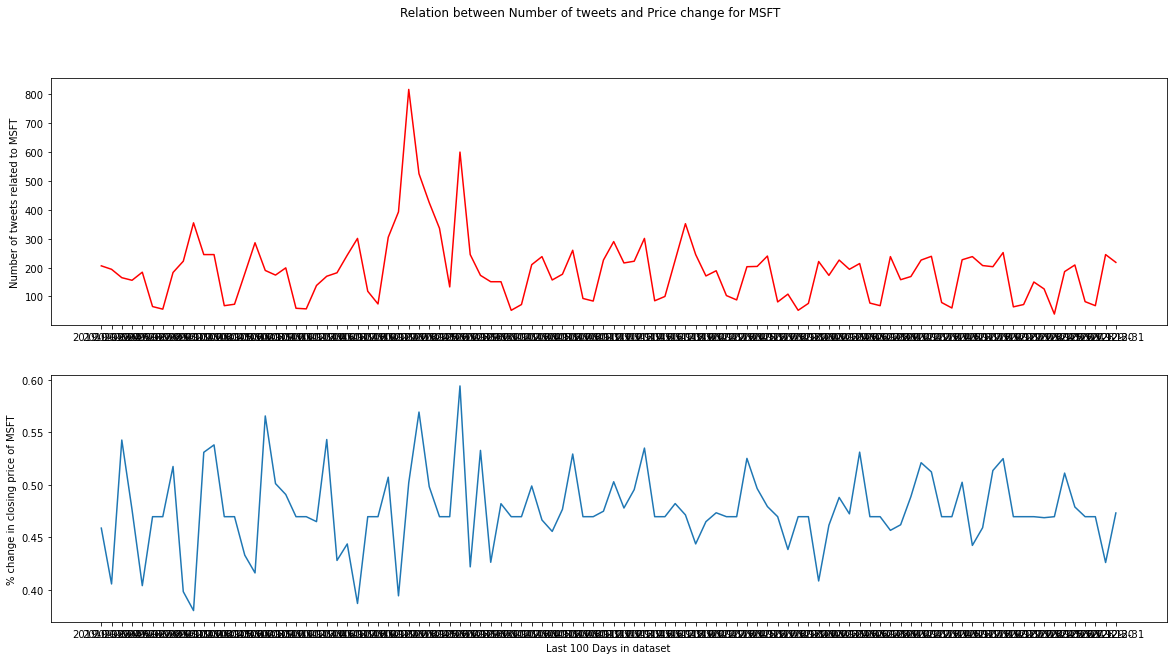

In [5]:
companies = data['ticker_symbol'].unique()

for company in companies:
    temp = data[data.ticker_symbol == company].groupby(['post_date']).count()
    temp1 = data[data.ticker_symbol == company].groupby(['post_date']).first()

    dates = np.array(temp['tweet_id'].keys())
    counts = np.array(temp['tweet_id'])
    value_changes = np.array(temp1['close_value_change'])

    minmax_scale(counts,copy=False)
    minmax_scale(value_changes,copy=False)
    print("\n"*5)
    fig = plt.figure(figsize=(20,10))
    fig.suptitle("Relation between Number of tweets and Price change for {}".format(company))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(dates[-100:],counts[-100:],'red')
    plt.ylabel("Number of tweets related to {}".format(company))


    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ax2.plot(dates[-100:],value_changes[-100:])
    plt.xlabel("Last 100 Days in dataset")
    plt.ylabel("% change in closing price of {}".format(company))
    plt.show()

<li> We can observe from above plots that for each company, number of tweets related to company and respective % price change do share spikes in plots. Whether these spikes are in similar direction or opposite, the % price change is related to number of tweets. </li>
<li> Spikes will be in similar direction if tweets have positive sentiments about the company. Similarly, spikes will be in opposite direction if tweets have negative sentiments about the company. </li>
<li> This indicates that by extracting information from these tweets will definitely help in predicting the change in share prices. </li>

#### With reference to discussion above, in this EDA and preprocessing file, the columns that were considered for analysis are: 'body', 'comment_num', 'retweet_num', 'like_num',  'post_date' and 'close_value_change' as class label.
#### With this conclusion , let us preprocess the tweet texts and other information related to tweets.

### 1. Preprocessing and EDA of Tweet text Column ('body' Column)

#### 1.1 Extracting Information before processing

<li> Before cleaning tweet data, let us extract features from uncleaned tweets such as hashtags, urls, mentions etc. </li> 

#### 1.1.1 URL_flag

Flag to represent whether an URL is present in tweet or not

In [6]:
# function to know whether the URL is present in the tweet text or not
def Find_url(string):  
    return ('https' in string or 'http' in string)


data['URL_flag'] = data.body.apply(lambda x:1 if Find_url(x) else 0)

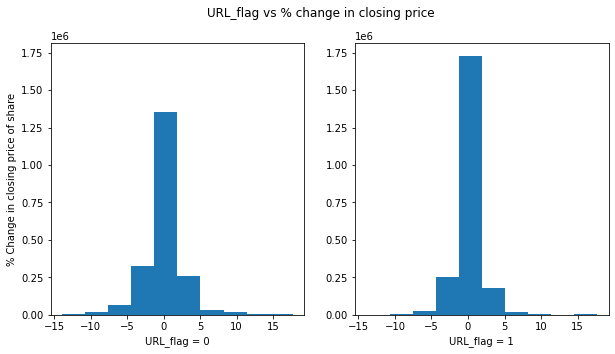

In [7]:
# Plotting URL flag vs Class label
fig = plt.figure(figsize=(10,5))
fig.suptitle("URL_flag vs % change in closing price")
ax1 = fig.add_subplot(1,2,1)
ax1.hist(data[data.URL_flag == 0]['close_value_change'].values)
plt.xlabel("URL_flag = 0")
plt.ylabel("% Change in closing price of share")


ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.hist(data[data.URL_flag == 1]['close_value_change'].values)
plt.xlabel("URL_flag = 1")
plt.show()

<li> Although % change distribution is almost similar, but we can extract some information from this feature that for URL_flag =1 more number of points are there around 0% change in closing price. </li>

#### 1.1.2 hastags_flag

Flag to represent whether hashtags are present in text or not

In [8]:
# referred below link to extract hashtags from tweets
# https://www.geeksforgeeks.org/python-extract-hashtags-from-text/

# fuunction to know whether hashtags are present in tweet text or not
def Find_hashtag(string):
    temp = re.search(r"#(\w+)", string)     
    return temp

# Extracting hashtag_flag feature
data['hastags_flag'] = data.body.apply(lambda x:1 if Find_hashtag(x) else 0)

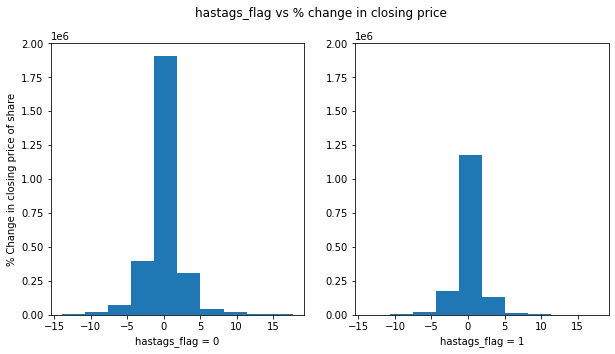

In [9]:
# Plotting hashtag_flag vs Class label
fig = plt.figure(figsize=(10,5))
fig.suptitle("hastags_flag vs % change in closing price")
ax1 = fig.add_subplot(1,2,1)
ax1.hist(data[data.hastags_flag == 0]['close_value_change'].values)
plt.xlabel("hastags_flag = 0")
plt.ylabel("% Change in closing price of share")


ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.hist(data[data.hastags_flag == 1]['close_value_change'].values)
plt.xlabel("hastags_flag = 1")
plt.show()

<li> We can see here that there are more points near 0% change when hashtags are absent i.e. hashtag_flag=0. This makes sense since hashtags are the reason to make tweets trend and the respective topics are discussed more. </li>

#### 1.1.3 mention_flag

Flag to represent whether another user was mentioned or not

In [10]:
# referred and modified below link to extract hashtags from tweets
# https://www.geeksforgeeks.org/python-extract-hashtags-from-text/
def Find_mention(string):
    temp = re.search(r"@(\w+)", string)     
    return temp

# extracting mention_flag features
data['mention_flag'] = data.body.apply(lambda x:1 if Find_mention(x) else 0)

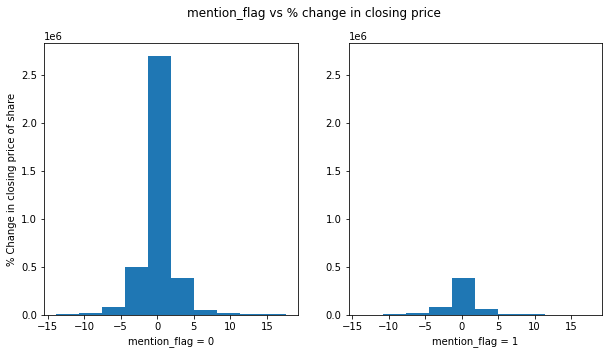

In [11]:
# Plotting mention_flag vs Class label
fig = plt.figure(figsize=(10,5))
fig.suptitle("mention_flag vs % change in closing price")
ax1 = fig.add_subplot(1,2,1)
ax1.hist(data[data.mention_flag == 0]['close_value_change'].values)
plt.xlabel("mention_flag = 0")
plt.ylabel("% Change in closing price of share")


ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.hist(data[data.mention_flag == 1]['close_value_change'].values)
plt.xlabel("mention_flag = 1")
plt.show()

<li> We can see if mentions are absent then there are more points near 0% change and this makes sense since to get attention of users to a particular tweet, user mentions are done. Hence This feature is an useful feature for change prediction. </li>

#### 1.1.4 Hashtag embedding

<li> In one of the research papers mentioned, one of the ways of embedding hashtags was demonstrated by taking average of letter vectors of hashtag words. </li>
<li> In order to use hashtag embeddings as a feature, let us extract hashtags from tweet text now so that we can remove those while cleaning text data. </li>

In [12]:
# referred below link to extract hashtags from tweets
# https://www.geeksforgeeks.org/python-extract-hashtags-from-text/

def get_hashtag(string):
    hashtags  = re.findall(r"#(\w+)", string)
    return hashtags

# extracting and storing hashtags in dataframe
data['hashtags'] = data.body.apply(lambda x:','.join(get_hashtag(x)))

In [13]:
# Some of the extracted hashtags are listed as follows:

data['hashtags'].values[:10]

array(['TOPTICKERTWEETS,sentiquant', 'SENTISHIFTUP,sentiquant', 'TUAW',
       '', '', '', '', '', '', ''], dtype=object)

<li> We can see empty string for tweets where hashtags are not present. In this case, one standard vector such as all zeros or all ones can be considered while vectorising these tweets. </li>

#### 1.2 Processing 'body' Column containing tweet text

In [14]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]



# referred this cleaning function from Donor Choose assignments
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r"#(\w+)", '', text)
    text = re.sub(r"@(\w+)", '', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('\\"', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('\\"', ' ')
        # https://gist.github.com/sebleier/554280
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    return text


# cleaning tweet text and storing in 'tweet_cleaned' column
data['tweet_cleaned'] = data.body.apply(lambda x:preprocess(x))

#### 1.3 Extracting Sentiments from cleaned text

<li> Social media is all about expressing thoughts and sentiments. Hence the sentiment analysis is done in order to extract sentiment features from cleaned tweet text data. </li>

In [15]:
# referred below link to get sentiments from cleaned tweets
# https://www.nltk.org/howto/sentiment.html

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

senti_score_train = [sid.polarity_scores(x_body) for x_body in tqdm(data['tweet_cleaned'])]


data['neg'] = [senti['neg'] for senti in senti_score_train]
data['neu'] = [senti['neu'] for senti in senti_score_train]
data['pos'] = [senti['pos'] for senti in senti_score_train]
data['compound'] = [senti['compound'] for senti in senti_score_train]

100%|██████████████████████████████████████████████████████████████████████| 4336445/4336445 [10:55<00:00, 6618.18it/s]


### 2. EDA of remaining features

In [16]:
data.columns

Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num', 'retweet_num', 'like_num', 'close_value', 'volume',
       'open_value', 'high_value', 'low_value', 'close_value_change',
       'change_label', 'class_sign', 'URL_flag', 'hastags_flag',
       'mention_flag', 'hashtags', 'tweet_cleaned', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')

#### 2.1 retweet_num

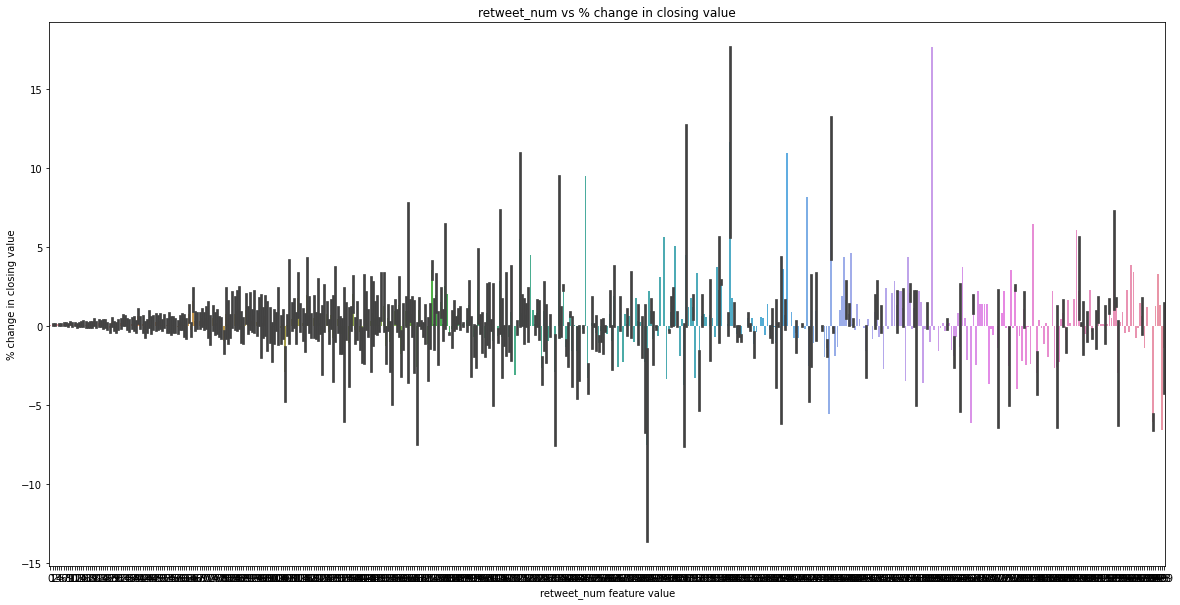

In [17]:
# visualising retweet_num feature

plt.figure(figsize=(20,10))
sns.barplot(x="retweet_num", y="close_value_change", data=data)
plt.xlabel("retweet_num feature value")
plt.ylabel("% change in closing value")
plt.title("retweet_num vs % change in closing value")
plt.show()

<li> We can see from above plot that as retweet number increases, there is more change in price variations. Hence this can be an useful feature. </li>
<li> When we have low number of retweet number then there is less variation in price change hence these points can be removed from data in order to have more focused data. However ideal case would be to consider all tweets but computationally that will be much more expensive. </li>

In [18]:
# filtering all tweets with non-zero retweet number
print(data.shape)
data = data[data.retweet_num > 1]
print(data.shape)

(4336445, 25)
(318146, 25)


In [19]:
# Scaling data in 0 to 1

retweet_num_scalar = MinMaxScaler()
data['retweet_num'] = retweet_num_scalar.fit_transform(data['retweet_num'].values.reshape(-1,1))

#### 2.2 comment_num

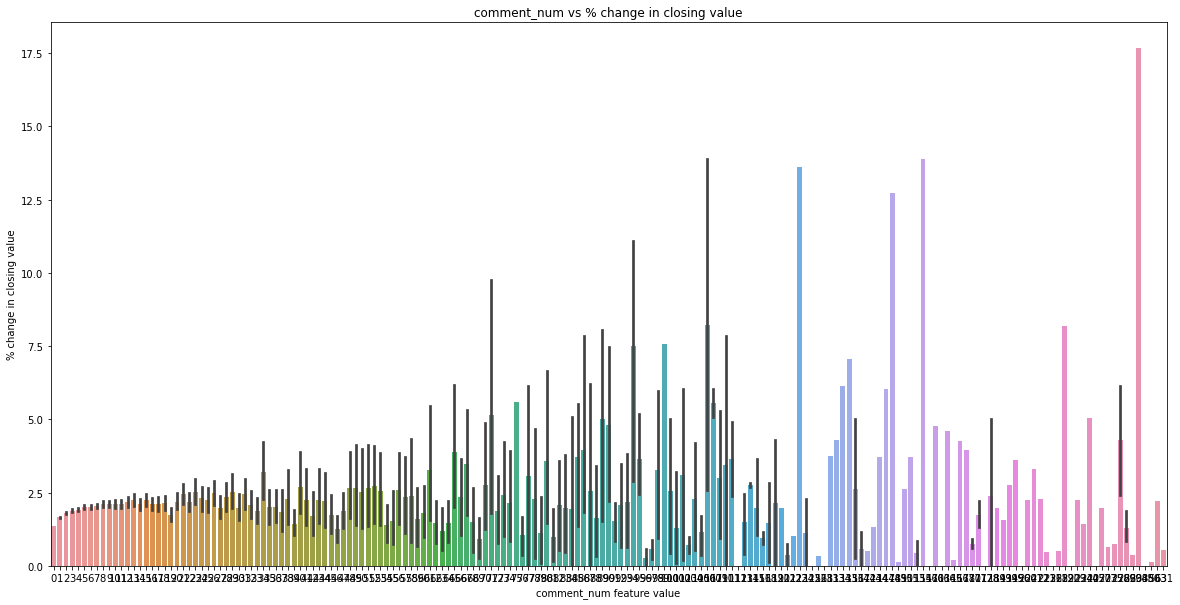

In [20]:
# visualising comment_num feature

plt.figure(figsize=(20,10))
sns.barplot(x="comment_num", y="change_label", data=data)
plt.xlabel("comment_num feature value")
plt.ylabel("% change in closing value")
plt.title("comment_num vs % change in closing value")
plt.show()

<li> As we can see that as comment number increases the price variation increases and this makes sense since with more number of comments, more number of users will be involved. </li>

In [21]:
comment_num_scalar = MinMaxScaler()
data['comment_num'] = comment_num_scalar.fit_transform(data['comment_num'].values.reshape(-1,1))

#### 2.3 like_num

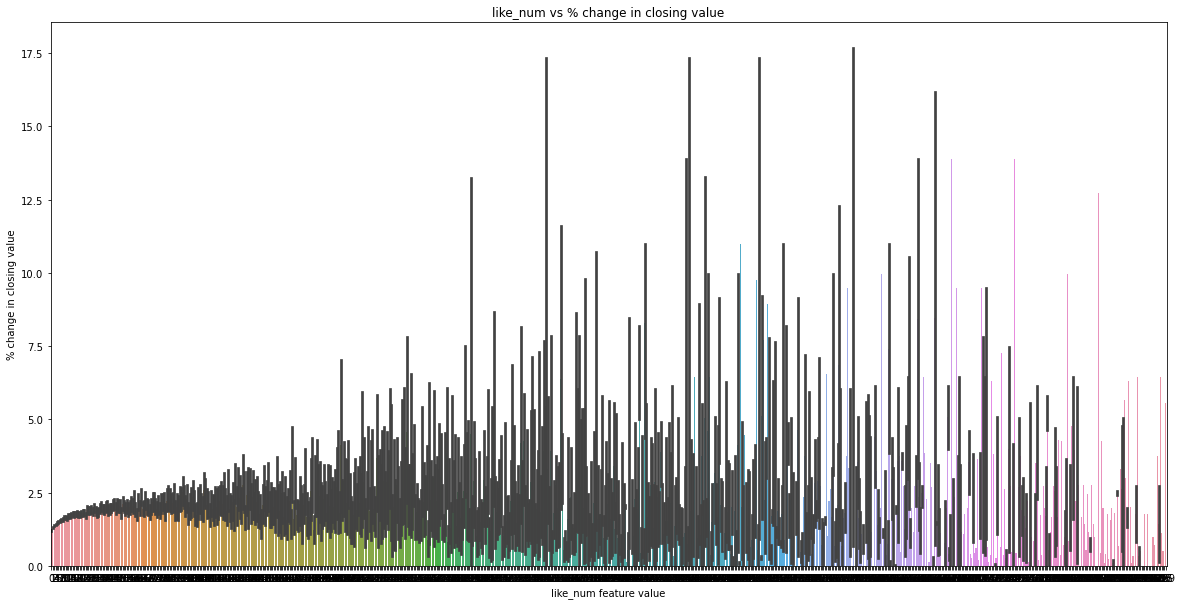

In [22]:
# visualising like_num feature

plt.figure(figsize=(20,10))
sns.barplot(x="like_num", y="change_label", data=data)
plt.xlabel("like_num feature value")
plt.ylabel("% change in closing value")
plt.title("like_num vs % change in closing value")
plt.show()

<li> Similar to previous two features, like number also represents the involvement of users and hence as like number increases, more variations in price variations can be seen. </li>

In [23]:
# Scaling data in 0 to 1
like_num_scalar = MinMaxScaler()
data['like_num'] = like_num_scalar.fit_transform(data['like_num'].values.reshape(-1,1))

In [24]:
scalars = pickle.dump([retweet_num_scalar,comment_num_scalar,like_num_scalar],open("scalars.pkl","wb"))

## 3. Saving Final File

In [25]:
print("The cleaned data has columns : ", data.columns)

The cleaned data has columns :  Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num', 'retweet_num', 'like_num', 'close_value', 'volume',
       'open_value', 'high_value', 'low_value', 'close_value_change',
       'change_label', 'class_sign', 'URL_flag', 'hastags_flag',
       'mention_flag', 'hashtags', 'tweet_cleaned', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')


In [26]:
# Based on EDA below columns are useful in training the model

data = data[['post_date','ticker_symbol','tweet_id','comment_num','retweet_num','like_num','URL_flag','hastags_flag',
            'mention_flag','hashtags','tweet_cleaned','neg','neu','pos','compound','change_label','class_sign','close_value_change']]

# saving processed data
data.to_csv("preprocessed_data.csv",index=False)

### The Vectorization of all features and scaling for numerical features is demonstrated in 'getting_structured_data.ipynb' file.